In [1]:
import sys
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_processing import matrices_assembly as ma
    from fem_pos_processing import graph_results, fem_analysis
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 1: Poisson Problem at $L$ Domain   

Considere a geometria L apresentada na Figura $(1)$.

<figure>
    <img src="pre_processing/pictures/L_domain.png" alt="Fig.1" style="width:20%;" />
    <figcaption>Figure 1: Geometry of L domain.</figcaption>
</figure>

Não há cargas no domínio e a solução exata para o problema é

$$
V(r, \theta) = r^{2/3} sin \left( \frac{2\theta}{3} + \frac{\pi}{3} \right)
\tag{1}
$$

onde $r$ e $\theta$ são as coordenadas polares, 

$$
\begin{cases}
r = \sqrt{x^2 + y^2}  \\
\theta = arctan(y/x) \tag{2}
\end{cases}
$$

A variação de $\theta$ para a geometria é $-\pi/2 \leq \theta \leq \pi$.

As condições de contorno são todas de Dirichlet e podem ser calculadas utilizando a expressão da solução exata sobre as fronteiras.

Usar malhas com densidades diferentes e verificar a convergência da sua solução à medida que refinna a malha. Calcule os erros na norma $L_2$ e na norma de energia. A melhor forma de verificar a convergência é traçar gráfios em escala _log-log_ da norma do erro em função de h. Se tudo estiver correto, em escala _log-log_ você obterá retas cujas inclinações fornecerão as taxas de convergência.

# `setTypeProblem()`

In [2]:
def setTypeProblem(FINITE_ELEMENT, h):
    # Create mesh using gmsh
    BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'omega'}]
    MATERIAL = [{'tag': 201, 'name': 'free_space', 'a_constant': 1}]
    
    # Create mesh Structure Data from gmsh
    mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h, auto_save=False)
    
    # Get FEM solution
    Agr, fgr, Mgr, Pgr, Qgr = ma.reduced_global_matrices(FINITE_ELEMENT, mesh_data)
    uhr = spsolve(Agr.tocsr(), fgr.toarray())
    uh =  ma.global_potentials_solution(mesh_data, uhr)
    return uh, mesh_data

# Convergence Analysis

In [3]:
element_types = [('Triangle', 1), ('Triangle', 2), ('Triangle', 3)]
#element_types = [('Quadrangle', 1), ('Quadrangle', 2)]
u_gradu = lambda x, y: ps.set_analytical_solution(x, y)
mesh_sizes = [1 / (2**i) for i in range(2, 6)]

# Inicialização dos dicionários para armazenar erros acumulados para cada tipo de elemento
errors_l2 = {et: [] for et in element_types}
errors_energy = {et: [] for et in element_types}

for h in mesh_sizes:  
    for FINITE_ELEMENT in element_types:  
        # Resolve a solução numérica uh para o tipo de elemento e refinamento de malha
        uh, mesh_data = setTypeProblem(FINITE_ELEMENT, h)  
        
        # Calcula o erro L2, o erro de energia e a energia total
        l2, energy, _ = fem_analysis.errors_and_energy(FINITE_ELEMENT, mesh_data, uh, u_gradu)

        # Acumula os erros nos dicionários correspondentes
        errors_l2[FINITE_ELEMENT].append(l2)
        errors_energy[FINITE_ELEMENT].append(energy)

# Figure 1: Convergence of the numerical solution for $L_2$ norm of the error

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p13_poisson_problem_L\pos_processing\pictures\convergence_L2.svg


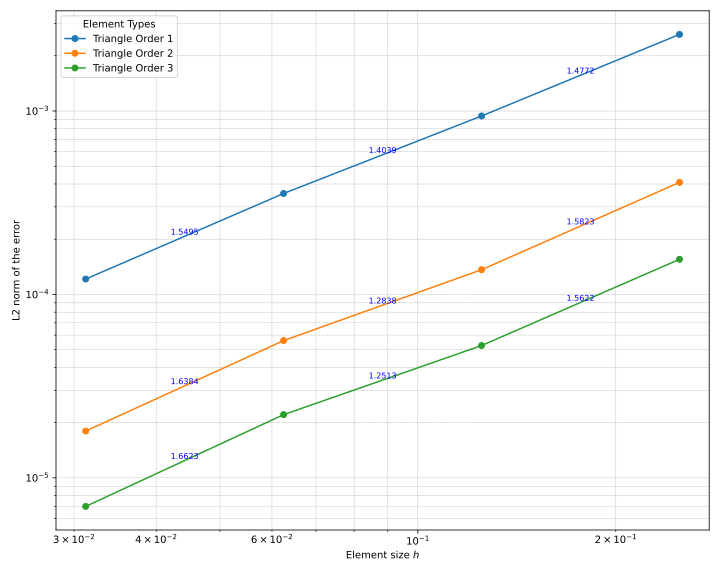

In [5]:
graph_results.plot_convergence(mesh_sizes, errors_l2, type='L2')
display(SVG(filename="pos_processing/pictures/convergence_L2.svg"))

# Figure 2: Convergence of the numerical solution for Energy norm of the error

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p13_poisson_problem_L\pos_processing\pictures\convergence_Energy.svg


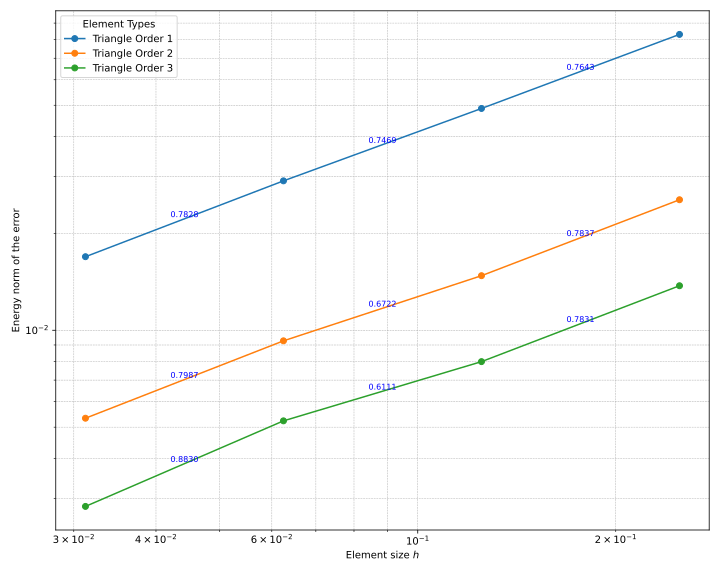

In [6]:
graph_results.plot_convergence(mesh_sizes, errors_energy, type='Energy')
display(SVG(filename="pos_processing/pictures/convergence_Energy.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.